In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Exclusions and Outliers
-- 3 subject sub-5f706a963b6ac2627a4bb3b5 & sub-611c31c77df20ecc6881cc44 reported 0 variance distributions

In [2]:
sub_df=[]
subs=os.listdir('bids')
for sub in subs:
    #print(sub)
    if sub not in['sub-5f706a963b6ac2627a4bb3b5','sub-611c31c77df20ecc6881cc44',
                 'sub-5d8aa95dd06260000179442b']:#reported 0 variance distributions
        mem=pd.read_csv('bids/%s/%s_mem-report.tsv'%(sub,sub),sep='\t')
        mem.percent=mem.percent.astype(int)

        mem['value']=mem['value'].astype(int)
        mem.loc[mem['value'] < 0, 'value'] = 0
        mem=pd.DataFrame(mem.values.repeat(mem.value, axis=0), columns=mem.columns)
        mem.percent=mem.percent.astype(int)
        mem['order']=mem['order'].astype(int)
        mem['value']=mem['value'].astype(int)
        mem=mem[['dist','percent','value','order']]
        O_df=mem.groupby('dist').mean().reset_index()
        order_var=O_df[O_df['dist']=='wide']['order'].values-O_df[O_df['dist']=='narrow']['order'].values
        if len(mem.groupby('dist').mean())>2:
            mem_df=pd.DataFrame()
            mem_df['dist']=['narrow','skew','wide']
            mem_df['narrow_first']=order_var[0]
            mem_df['means']=mem.groupby('dist').mean()['percent'].values
            mem_df['stds']=mem.groupby('dist').std()['percent'].values
            mem_df['skew']=mem.groupby('dist').skew()['percent'].values
            mem_df['sub']=(sub)
            sub_df.append(mem_df)
        else:
            #print(sub)
            pass
sub_df=pd.concat(sub_df)
sub_df=sub_df.reset_index()



In [3]:
import statsmodels.api as sm
row=[]
exclude=[]
for sub in sub_df['sub'].unique():
    df=pd.read_csv('bids/%s/%s_task-risk_run-1_events.tsv'%(sub,sub),
                   sep='\t')
    df['side'] = df['side'].apply(lambda x: x.replace('"', ''))
    df['side'] = df['side'].apply(lambda x: x.replace('[', ''))
    df['side'] = df['side'].apply(lambda x: x.replace(']', ''))
    df['choose_risk']=df['side']==df['select']
    if any(df[df['choose_risk']==False]['p1']==1):
        exclude.append(sub)
    elif any(df[df['choose_risk']==True]['p1']==0):
        exclude.append(sub)
    #else:
    #sns.lmplot(x='p1',y='choose_risk',logistic=True,data=df)
    Xtrain=df[['p1']]
    ytrain=df[['choose_risk']]
    log_reg = sm.OLS(ytrain, Xtrain).fit(disp=False)
    row.append([sub,log_reg.params['p1'],log_reg.pvalues['p1']])
    if log_reg.params['p1']<0:
        print(sub,log_reg.params['p1'],log_reg.pvalues['p1'])
        sns.lmplot(x='p1',y='choose_risk',data=df,logistic=False)
        plt.show()
Psens_df=pd.DataFrame(columns=['sub','coef','p'],data=row)
print("Out of %s participants an additional %s were excluded do to choice checks"%(len(
    sub_df['sub'].unique()),len(exclude)))
print("This leaves us with a total of %s"%(len(
    sub_df['sub'].unique())-len(exclude)))
sub_df=sub_df[~sub_df['sub'].isin(exclude)]

/home/strange/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse


Out of 295 participants an additional 68 were excluded do to choice checks
This leaves us with a total of 227


## Hypothesis 2a:
- Participants will be slower to change their decisions in response to feedback for ambiguous stimuli associated with a lower variance in the distribution of probability.
- H2a.) Choice ~ Probability * Distribution [‘narrow’, ‘wide’] * Feedback+ (1|sub) 

In [20]:
RL_df=[]
for sub in sub_df['sub'].unique():
    mem=pd.read_csv('bids/%s/%s_mem-report.tsv'%(sub,sub),sep='\t')
    RL=pd.read_csv('bids/%s/%s_task-learn_run-1_events.tsv'%(sub,sub),sep='\t')
    RL['sub']=sub
    RL['order']=sub_df[sub_df['sub']==sub]['narrow_first'].values[0]
    RL.loc[ RL["color"] == "red", "dist"] = mem[mem['Lot_color']=='R']['dist'].values[0]
    RL.loc[ RL["color"] == "green", "dist"] = mem[mem['Lot_color']=='G']['dist'].values[0]
    RL.loc[ RL["color"] == "blue", "dist"] = mem[mem['Lot_color']=='B']['dist'].values[0]
    RL_df.append(RL)
RL_df=pd.concat(RL_df)
print("no NA values for choice ",RL_df['choice'].unique())
RL_df['choose_risk']=RL_df['choice']=='risk'
print("no NA values for RL_feedback ",RL_df['RL_feedback'].unique())
RL_df['full_A']=RL_df['Amb']=='[0,1]'
print("no NA values for dist ",RL_df['dist'].unique())
RL_df['wide_dist']=RL_df['dist']=='wide'
RL_df['dist_Feed']=0
RL_df.loc[ (RL_df["dist"] == "wide")&(RL_df["RL_feedback"] == "win"),
       "dist_Feed"] = 1
RL_df.loc[ (RL_df["dist"] == "wide")&(RL_df["RL_feedback"] == "lose"),
       "dist_Feed"] = -1
RL_df.loc[ (RL_df["dist"] == "narrow")&(RL_df["RL_feedback"] == "win"),
       "dist_Feed"] = .5
RL_df.loc[ (RL_df["dist"] == "narrow")&(RL_df["RL_feedback"] == "lose"),
       "dist_Feed"] = -.5
print("",RL_df['dist_Feed'].unique())


RL_df.head()


no NA values for choice  ['risk' 'Amb']
no NA values for RL_feedback  ['lose' 'win']
no NA values for dist  ['wide' 'skew' 'narrow']
 [-1.   0.  -0.5  1.   0.5]


,Blocktype,tnum,rt,color,per,Amb,RL_feedback,choice,dist,side,response,sub,order,choose_risk,full_A,wide_dist,dist_Feed
0,Learning,1.0,1128.0,blue,0.50,"[0,1]",lose,risk,wide,right,j,sub-5858b2ca83a02d0001e38fd2,-1.0,True,True,True,-1.0
1,Learning,2.0,1603.0,blue,0.39,"[0,1]",lose,Amb,wide,left,j,sub-5858b2ca83a02d0001e38fd2,-1.0,False,True,True,-1.0
2,Learning,3.0,1284.0,blue,0.45,"[0,1]",lose,risk,wide,left,f,sub-5858b2ca83a02d0001e38fd2,-1.0,True,True,True,-1.0
3,Learning,4.0,1540.0,blue,0.40,"[0,1]",lose,risk,wide,right,j,sub-5858b2ca83a02d0001e38fd2,-1.0,True,True,True,-1.0
4,Learning,5.0,572.0,blue,0.35,"[0,1]",lose,Amb,wide,right,f,sub-5858b2ca83a02d0001e38fd2,-1.0,False,True,True,-1.0


In [21]:
from pymer4.models import Lmer
model_df=RL_df[RL_df['dist'].isin(['wide','narrow'])]
print("",model_df['dist_Feed'].unique())


model = Lmer("choose_risk  ~ per+dist_Feed  + (1|sub)",
             data=model_df, family = 'binomial')
display(model.fit())
#display(model.fit(factors={"dist_Feed": {"Wide_lose": 1, "narrow_lose": -0.5, "narrow_win": 0.5, "Wide_win": 1}}))


 [-1.  -0.5  1.   0.5]
Formula: choose_risk~per+dist_Feed+(1|sub)

Family: binomial	 Inference: parametric

Number of observations: 13410	 Groups: {'sub': 224.0}

Log-likelihood: -8882.406 	 AIC: 17772.812

Random effects:

            Name    Var    Std
sub  (Intercept)  0.394  0.627

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-2.285,-2.479,-2.090,0.099,0.102,0.084,0.124,0.092,0.077,0.110,-22.998,0.0,***
per,4.270,3.913,4.627,0.182,71.537,50.071,102.206,0.986,0.980,0.990,23.459,0.0,***
dist_Feed,-0.225,-0.272,-0.178,0.024,0.798,0.762,0.837,0.444,0.432,0.456,-9.358,0.0,***


In [19]:
model.plot("dist_Feed", plot_ci=True, ylabel="choose_risk")

NotImplementedError: Plotting can currently only handle models with continuous predictors!

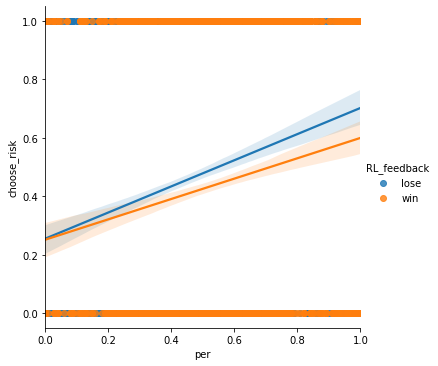

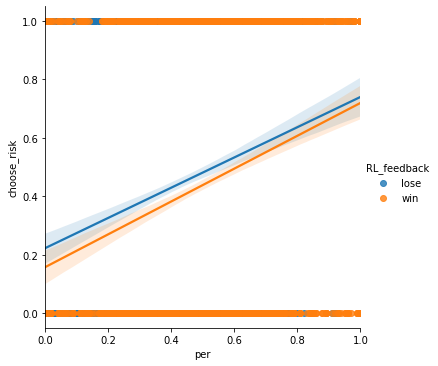

In [7]:
plot_df=RL_df[RL_df['dist']=='wide']
sns.lmplot(x='per',y='choose_risk',hue='RL_feedback',data=plot_df,logistic=False)
plot_df=RL_df[RL_df['dist']=='narrow']
sns.lmplot(x='per',y='choose_risk',hue='RL_feedback',data=plot_df,logistic=False)
plt.show()